In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from matplotlib import animation
from matplotlib.animation import PillowWriter

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

# Extract Data

In [2]:
name = '10k_0.01M_90quantile_t15'

theta = 0.05
eps = 0.0075
      
b = 0.1      

One can decide whether to extract time, positions and velocities from the `.out` file or to import the data from previously-saved numpy arrays.

In [3]:
import_from_saved_nparrays = True
save_arrays = False

# Import the data from previously-saved numpy arrays...
if import_from_saved_nparrays:
    time = np.load('numpy_arrays/'+name+'_time.npy')
    masses = np.load('numpy_arrays/'+name+'_masses.npy')
    x = np.load('numpy_arrays/'+name+'_x.npy')
    y = np.load('numpy_arrays/'+name+'_y.npy')
    z = np.load('numpy_arrays/'+name+'_z.npy')
    vx = np.load('numpy_arrays/'+name+'_vx.npy')
    vy = np.load('numpy_arrays/'+name+'_vy.npy')
    vz = np.load('numpy_arrays/'+name+'_vz.npy')
    N = int(len(x[:,0]))

    print(f'This is the data of {N} particles at {len(time)} time intervals')
    
    
# or extract it from the '.out' file
else:
    # Extract the data by reading one line of the file at a time
    extension = '.out'

    file = open('./project_'+name+extension, 'r')

    N = int(file.readline())
    time = []
    masses = []
    x = []
    y = []
    z = []
    vx = []
    vy = []
    vz = []

    step = 3 + 3*N
    i = 1
    j = 0

    while(True):   
        line = file.readline()

        if line=='':
            file.close()
            break
        
        i += 1

        k = i-j*step
        if (k==3): time.append(float(line))
        elif (j==0 and (k > 3 and k <= 3+N)): 
            masses.append(float(line))
        elif (k > 3+N and k <= 3+2*N): 
            line = [float(x) for x in line.split()]
            x.append(line[0])
            y.append(line[1])
            z.append(line[2])
        elif (k > 3+2*N and k <= 3+3*N):
            line = [float(x) for x in line.split()]
            vx.append(line[0])
            vy.append(line[1])
            vz.append(line[2])

        if i%step==0: j += 1
        
    # Convert the data from lists to numpy arrays 
    time = np.array(time)
    masses = np.array(masses)
    x = np.array(x).reshape(len(time), N).T
    y = np.array(y).reshape(len(time), N).T
    z = np.array(z).reshape(len(time), N).T
    vx = np.array(vx).reshape(len(time), N).T
    vy = np.array(vy).reshape(len(time), N).T
    vz = np.array(vz).reshape(len(time), N).T

    print(f'This is the data of {N} particles at {len(time)} time intervals')
    
    
    # If you want, you can save the data in form of numpy arrays
    if save_arrays:
        np.save('numpy_arrays/'+name+'_time.npy', time)
        np.save('numpy_arrays/'+name+'_masses.npy', masses)
        np.save('numpy_arrays/'+name+'_x.npy', x)
        np.save('numpy_arrays/'+name+'_y.npy', y)
        np.save('numpy_arrays/'+name+'_z.npy', z)
        np.save('numpy_arrays/'+name+'_vx.npy', vx)
        np.save('numpy_arrays/'+name+'_vy.npy', vy)
        np.save('numpy_arrays/'+name+'_vz.npy', vz)
        
M = np.sum(masses)
M_mbh = masses[-1]
print(f'M = {M:.4f}')
print(f'M_MBHs = {M_mbh:.4f}')

This is the data of 10002 particles at 7501 time intervals
M = 1.0200
M_MBHs = 0.0100


# Motion of the CM

Compute the position and the velocity of the center of mass as a function of time

$$\vec{r}_{CM}(t) = \dfrac{\sum_{i=1}^{N} m_i \vec{r}_i(t)}{\sum_{i=1}^{N} m_i} \:\:\: , \:\:\: \vec{r'}_i(t) = \vec{r}_i(t) - \vec{r}_{CM} (t)$$

$$\vec{v}_{CM} (t) = \dfrac{\sum_{i=1}^{N} m_i \vec{v}_i(t)}{\sum_{i=1}^{N} m_i} \:\:\: , \:\:\: \vec{v'}_i(t) = \vec{v}_i(t) - \vec{v}_{CM} (t)$$

In [4]:
CMpos_vector = np.array([np.dot(masses, x), np.dot(masses, y), np.dot(masses, z)])/M
CMpos = np.linalg.norm(CMpos_vector, axis=0)

CMvel_vector = np.array([np.dot(masses, vx), np.dot(masses, vy), np.dot(masses, vz)])/M
CMvel = np.linalg.norm(CMvel_vector, axis=0)

Compute the distance of each particle from the center of mass at each time

In [5]:
def Dist(x1, y1, z1, x2, y2, z2):
    return np.linalg.norm(np.array([x1-x2, y1-y2, z1-z2]), axis=0)

dist_particle = Dist(x, y, z, CMpos_vector[0], CMpos_vector[1], CMpos_vector[2])
print(dist_particle.shape)

(10002, 7501)


Plot the position of the center of mass as a function of time

  0%|          | 0/7501 [00:00<?, ?it/s]

100%|██████████| 7501/7501 [00:02<00:00, 2506.10it/s]


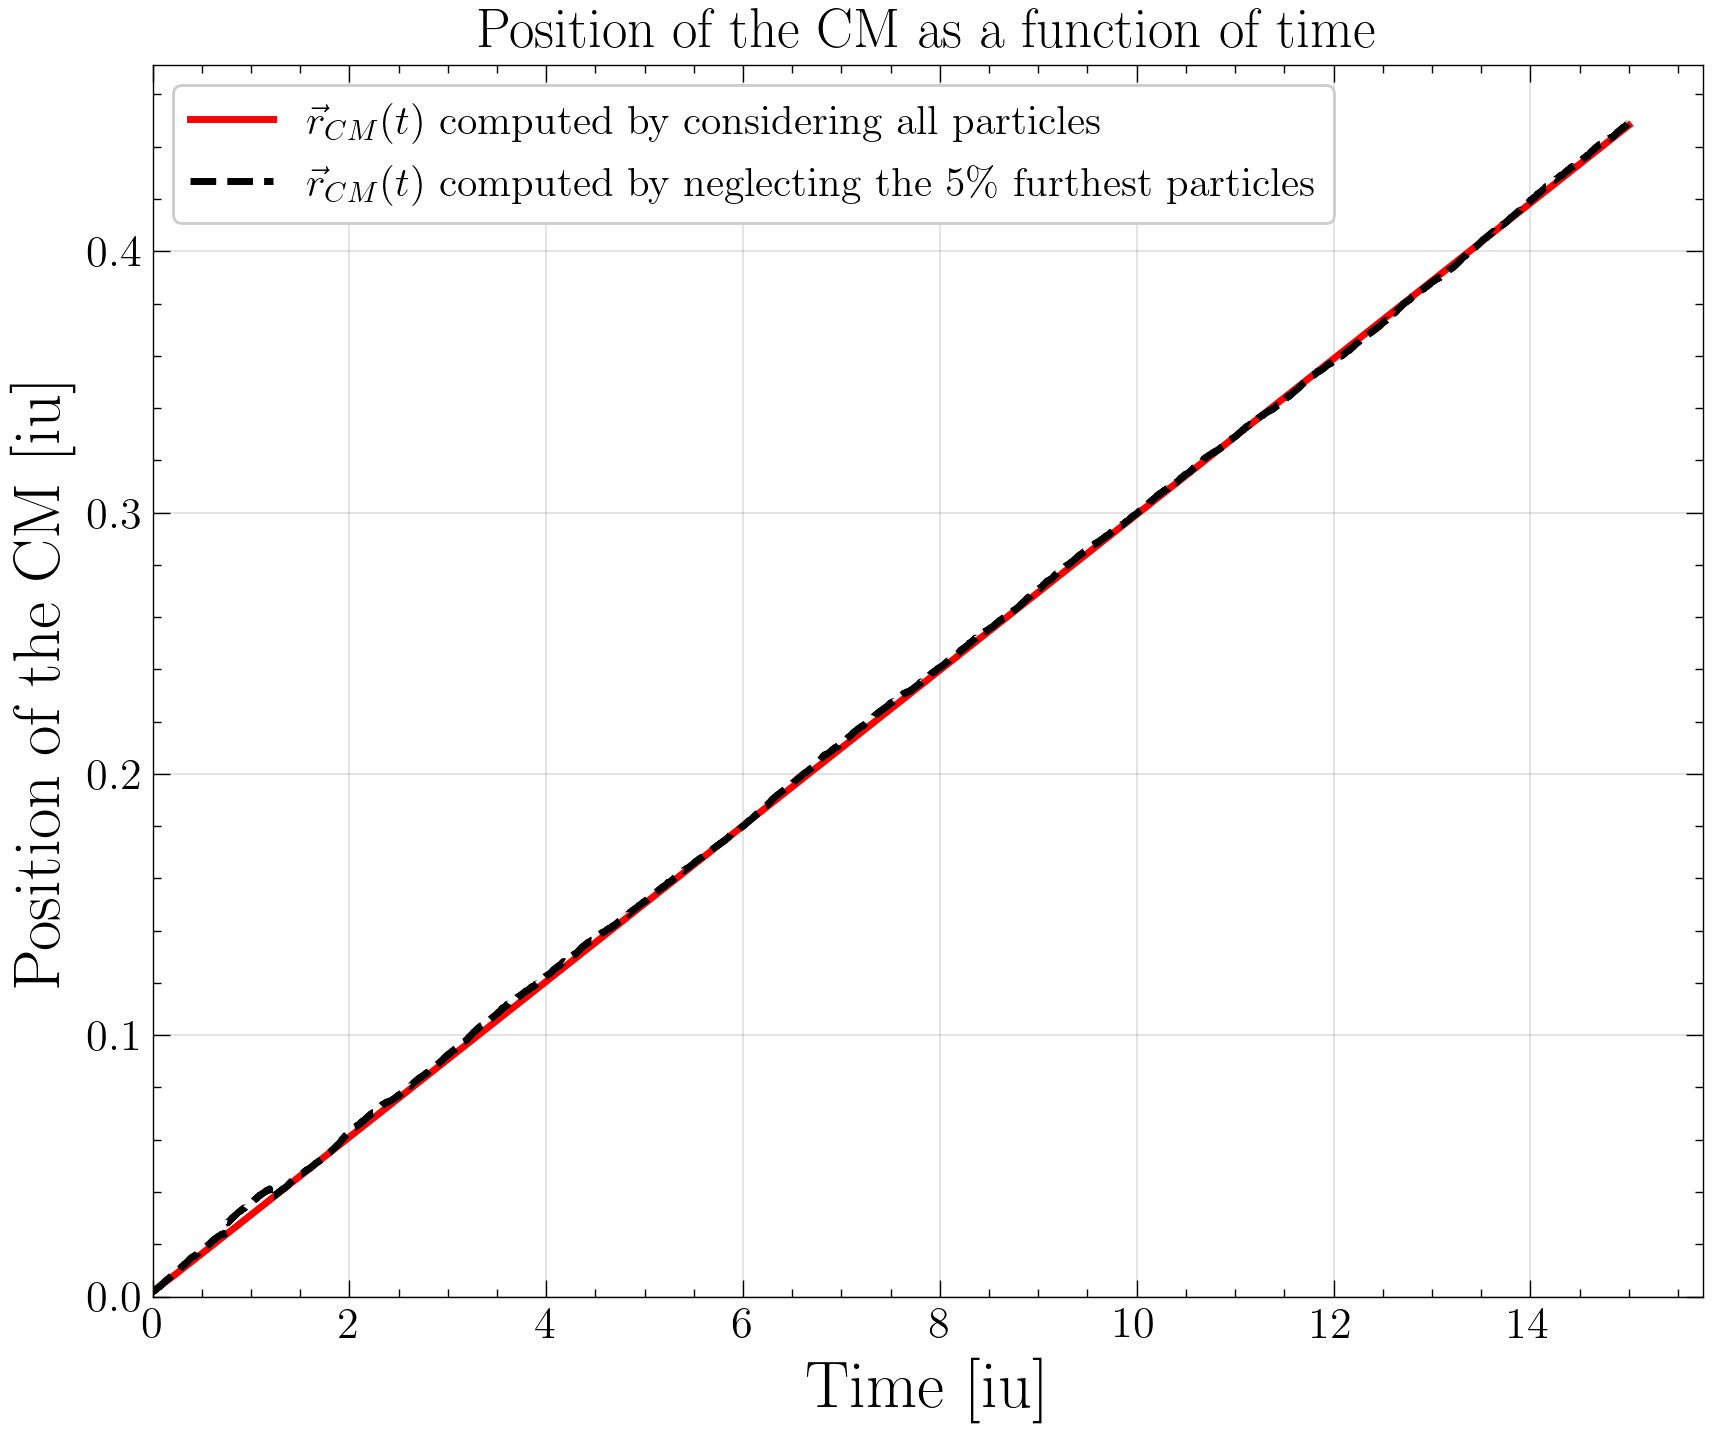

In [6]:
plt.plot(time, CMpos, color='red', lw=2.5, label='$\\vec{r}_{CM}(t)$ computed by considering all particles')

CMpos_q95_vector = np.zeros((3, len(time)))
for i in tqdm(range(len(time))):
    mask = dist_particle[:,i]<np.quantile(dist_particle[:,i], 0.95)
    CMpos_q95_vector[:,i] = np.array([np.dot(masses[mask], x[:,i][mask]), 
                                      np.dot(masses[mask], y[:,i][mask]), 
                                      np.dot(masses[mask], z[:,i][mask])])/np.sum(masses[mask])
CMpos_q95 = np.linalg.norm(CMpos_q95_vector, axis=0)

plt.plot(time, CMpos_q95, color='black', ls='--', lw=2.5, label='$\\vec{r}_{CM}(t)$ computed by neglecting the 5\% furthest particles')
plt.xlim(0)
plt.ylim(0)
plt.title('Position of the CM as a function of time', fontsize=20)
plt.xlabel('Time [iu]')
plt.ylabel('Position of the CM [iu]')
plt.legend(fontsize = 15);

Plot the velocity of the center of mass as a function of time

100%|██████████| 7501/7501 [00:03<00:00, 2492.13it/s]


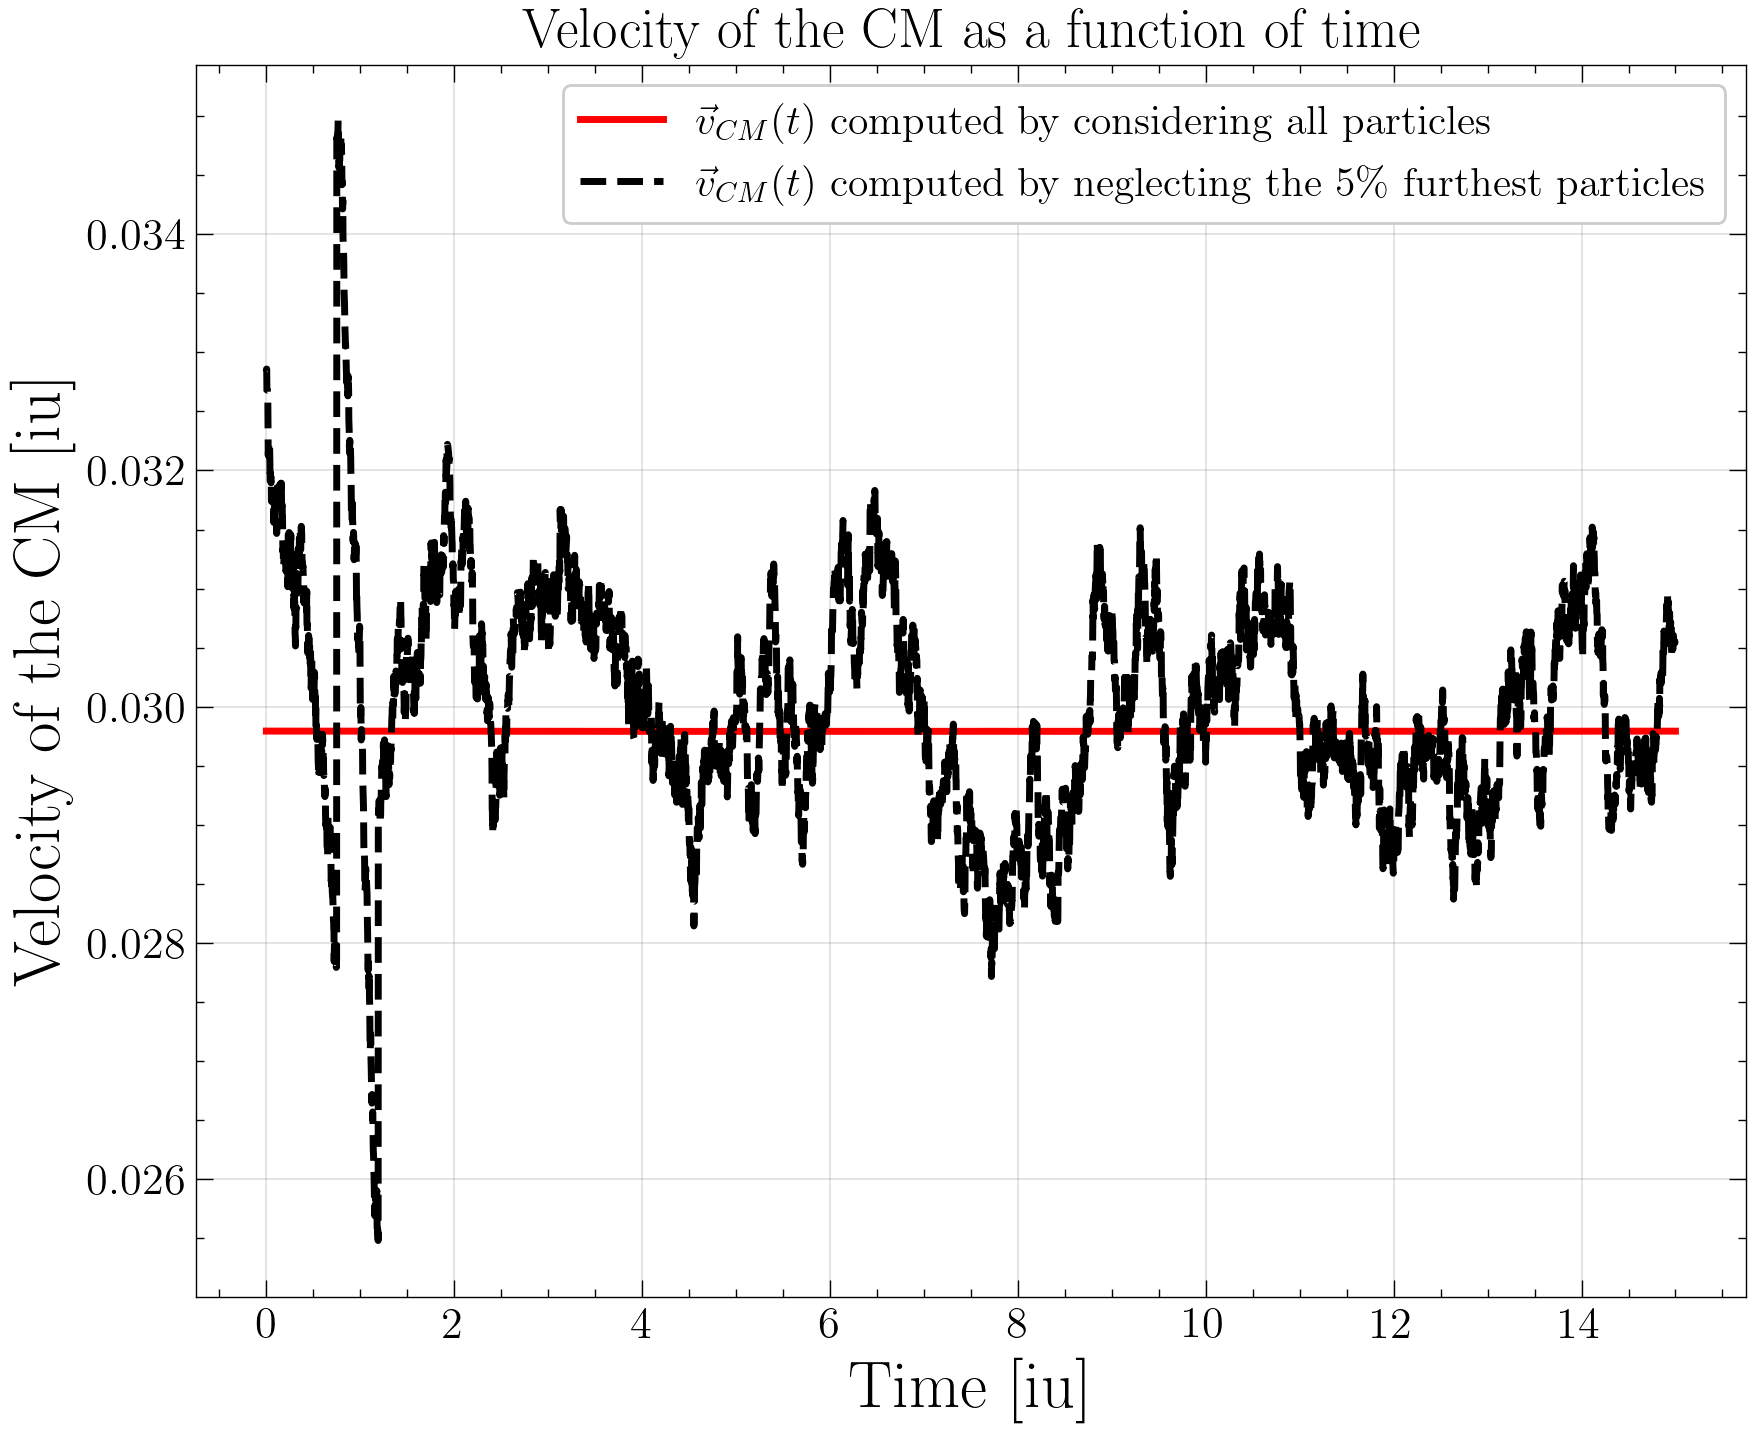

In [7]:
plt.plot(time, CMvel, color='red', lw=2.5, label='$\\vec{v}_{CM}(t)$ computed by considering all particles')

CMvel_q95_vector = np.zeros((3, len(time)))
for i in tqdm(range(len(time))):
    mask = dist_particle[:,i]<np.quantile(dist_particle[:,i], 0.95)
    CMvel_q95_vector[:,i] = np.array([np.dot(masses[mask], vx[:,i][mask]), 
                                      np.dot(masses[mask], vy[:,i][mask]), 
                                      np.dot(masses[mask], vz[:,i][mask])])/np.sum(masses[mask])
CMvel_q95 = np.linalg.norm(CMvel_q95_vector, axis=0)

plt.plot(time, CMvel_q95, color='black', ls='--', lw=2.5, label='$\\vec{v}_{CM}(t)$ computed by neglecting the 5\% furthest particles')
plt.title('Velocity of the CM as a function of time', fontsize=20)
plt.xlabel('Time [iu]')
plt.ylabel('Velocity of the CM [iu]')
plt.legend(fontsize = 15);

Redefine positions and velocities in the CM frame

In [8]:
x = x - CMpos_vector[0]
y = y - CMpos_vector[1]
z = z - CMpos_vector[2]
vx = vx - CMvel_vector[0]
vy = vy - CMvel_vector[1]
vz = vz - CMvel_vector[2]

We constrain our plots to boxes of length `dist_plotlimits` in each direction, which is defined as the maximum in time of the 90%-quantiles of the distances between the particles and the CM

In [9]:
dist_plotlimits = np.max(np.quantile(dist_particle, 0.9, axis=0))
dist_plotlimits

0.4101466873716317

# Orbit of the MBHs

In [10]:
dist_mbh1 = dist_particle[-1]
v_mbh1 = np.sqrt(vx[-1]**2 + vy[-1]**2 + vz[-1]**2)
angmom_mbh1 = np.linalg.norm(np.cross(np.array([x, y, z])[:,-1,:].T, np.array([vx, vy, vz])[:,-1,:].T), axis=1)

dist_mbh2 = dist_particle[-2]
v_mbh2 = np.sqrt(vx[-2]**2 + vy[-2]**2 + vz[-2]**2)
angmom_mbh2 = np.linalg.norm(np.cross(np.array([x, y, z])[:,-2,:].T, np.array([vx, vy, vz])[:,-2,:].T), axis=1)

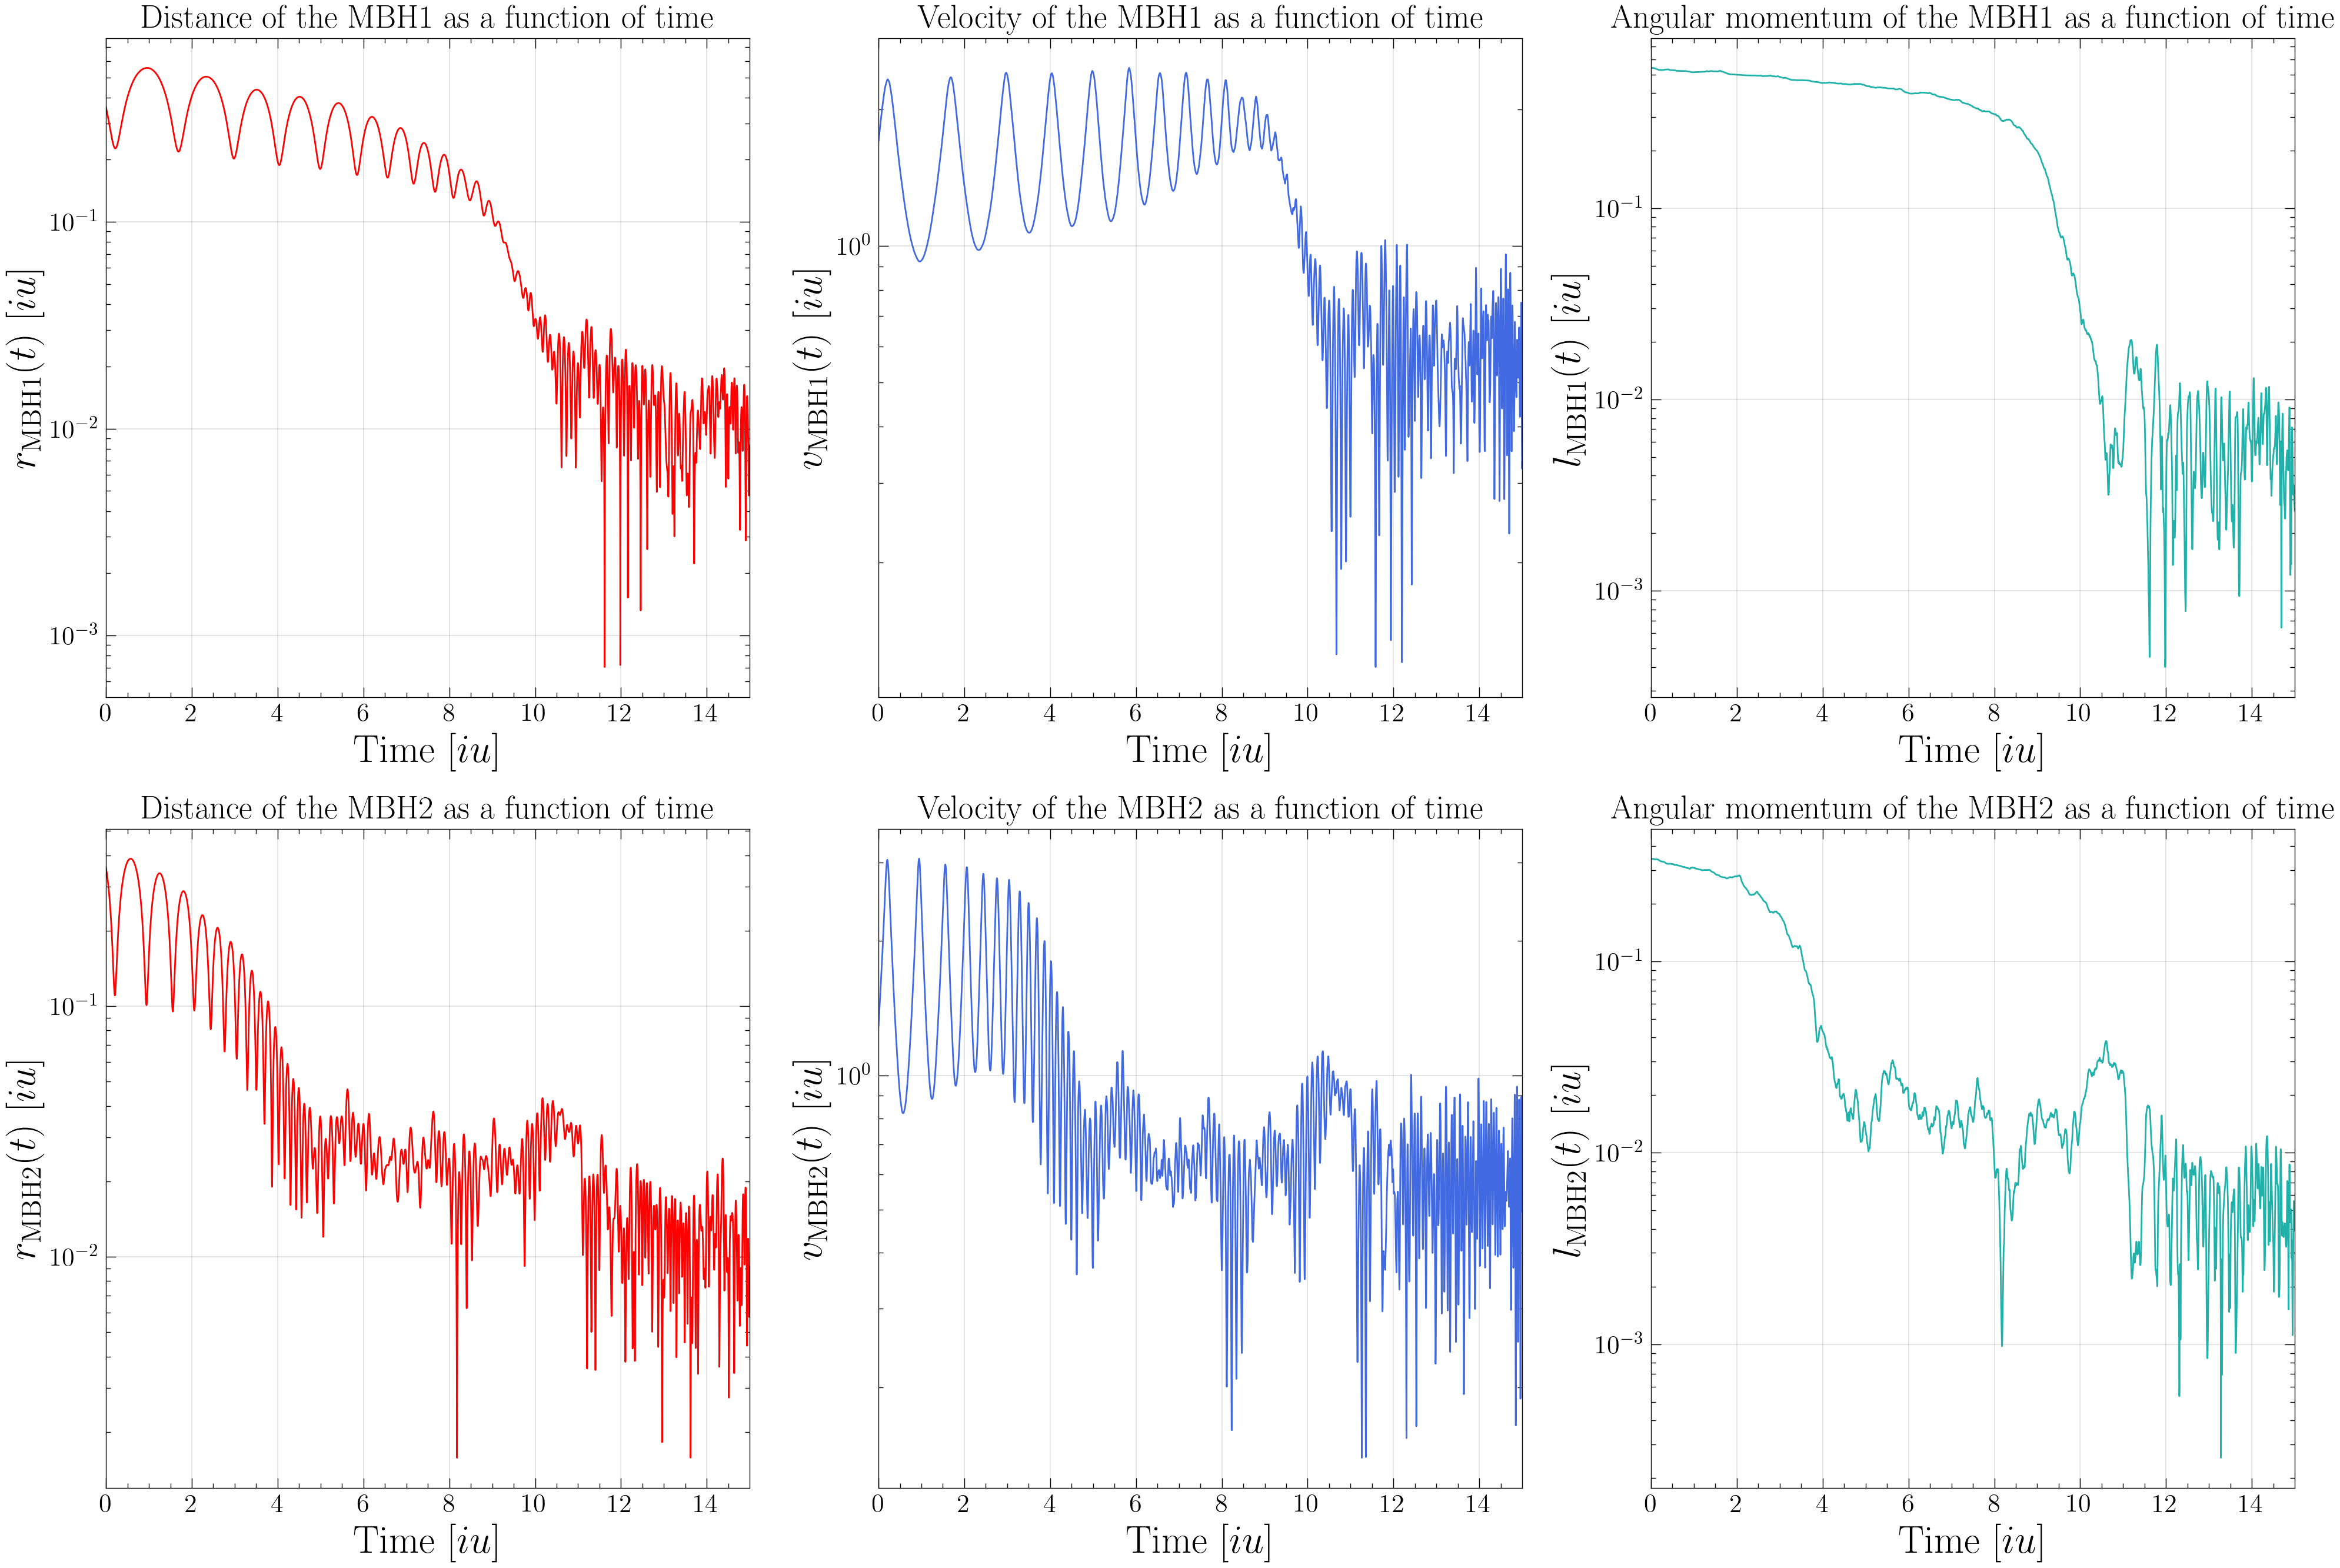

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

ax = axes[0,0]
ax.plot(time, dist_mbh1, color='red', lw=1)
ax.set_xlim(0, time[-1])
#ax.set_ylim(0)
ax.set_yscale('log')
ax.set_title('Distance of the MBH1 as a function of time', fontsize=20)
ax.set_xlabel('Time $[iu]$')
ax.set_ylabel('$r_{\\rm{MBH1}} (t)$ $[iu]$')

ax = axes[0,1]
ax.plot(time, v_mbh1, color='royalblue', lw=1)
ax.set_xlim(0, time[-1])
#ax.set_ylim(0)
ax.set_yscale('log')
ax.set_title('Velocity of the MBH1 as a function of time', fontsize=20)
ax.set_xlabel('Time $[iu]$')
ax.set_ylabel('$v_{\\rm{MBH1}} (t)$ $[iu]$')

ax = axes[0,2]
ax.plot(time, angmom_mbh1, color='lightseagreen', lw=1)
ax.set_xlim(0, time[-1])
#ax.set_ylim(0)
ax.set_yscale('log')
ax.set_title('Angular momentum of the MBH1 as a function of time', fontsize=20)
ax.set_xlabel('Time $[iu]$')
ax.set_ylabel('$l_{\\rm{MBH1}} (t)$ $[iu]$')

ax = axes[1,0]
ax.plot(time, dist_mbh2, color='red', lw=1)
ax.set_xlim(0, time[-1])
#ax.set_ylim(0)
ax.set_yscale('log')
ax.set_title('Distance of the MBH2 as a function of time', fontsize=20)
ax.set_xlabel('Time $[iu]$')
ax.set_ylabel('$r_{\\rm{MBH2}} (t)$ $[iu]$')

ax = axes[1,1]
ax.plot(time, v_mbh2, color='royalblue', lw=1)
ax.set_xlim(0, time[-1])
#ax.set_ylim(0)
ax.set_yscale('log')
ax.set_title('Velocity of the MBH2 as a function of time', fontsize=20)
ax.set_xlabel('Time $[iu]$')
ax.set_ylabel('$v_{\\rm{MBH2}} (t)$ $[iu]$')

ax = axes[1,2]
ax.plot(time, angmom_mbh2, color='lightseagreen', lw=1)
ax.set_xlim(0, time[-1])
#ax.set_ylim(0)
ax.set_yscale('log')
ax.set_title('Angular momentum of the MBH2 as a function of time', fontsize=20)
ax.set_xlabel('Time $[iu]$')
ax.set_ylabel('$l_{\\rm{MBH2}} (t)$ $[iu]$');

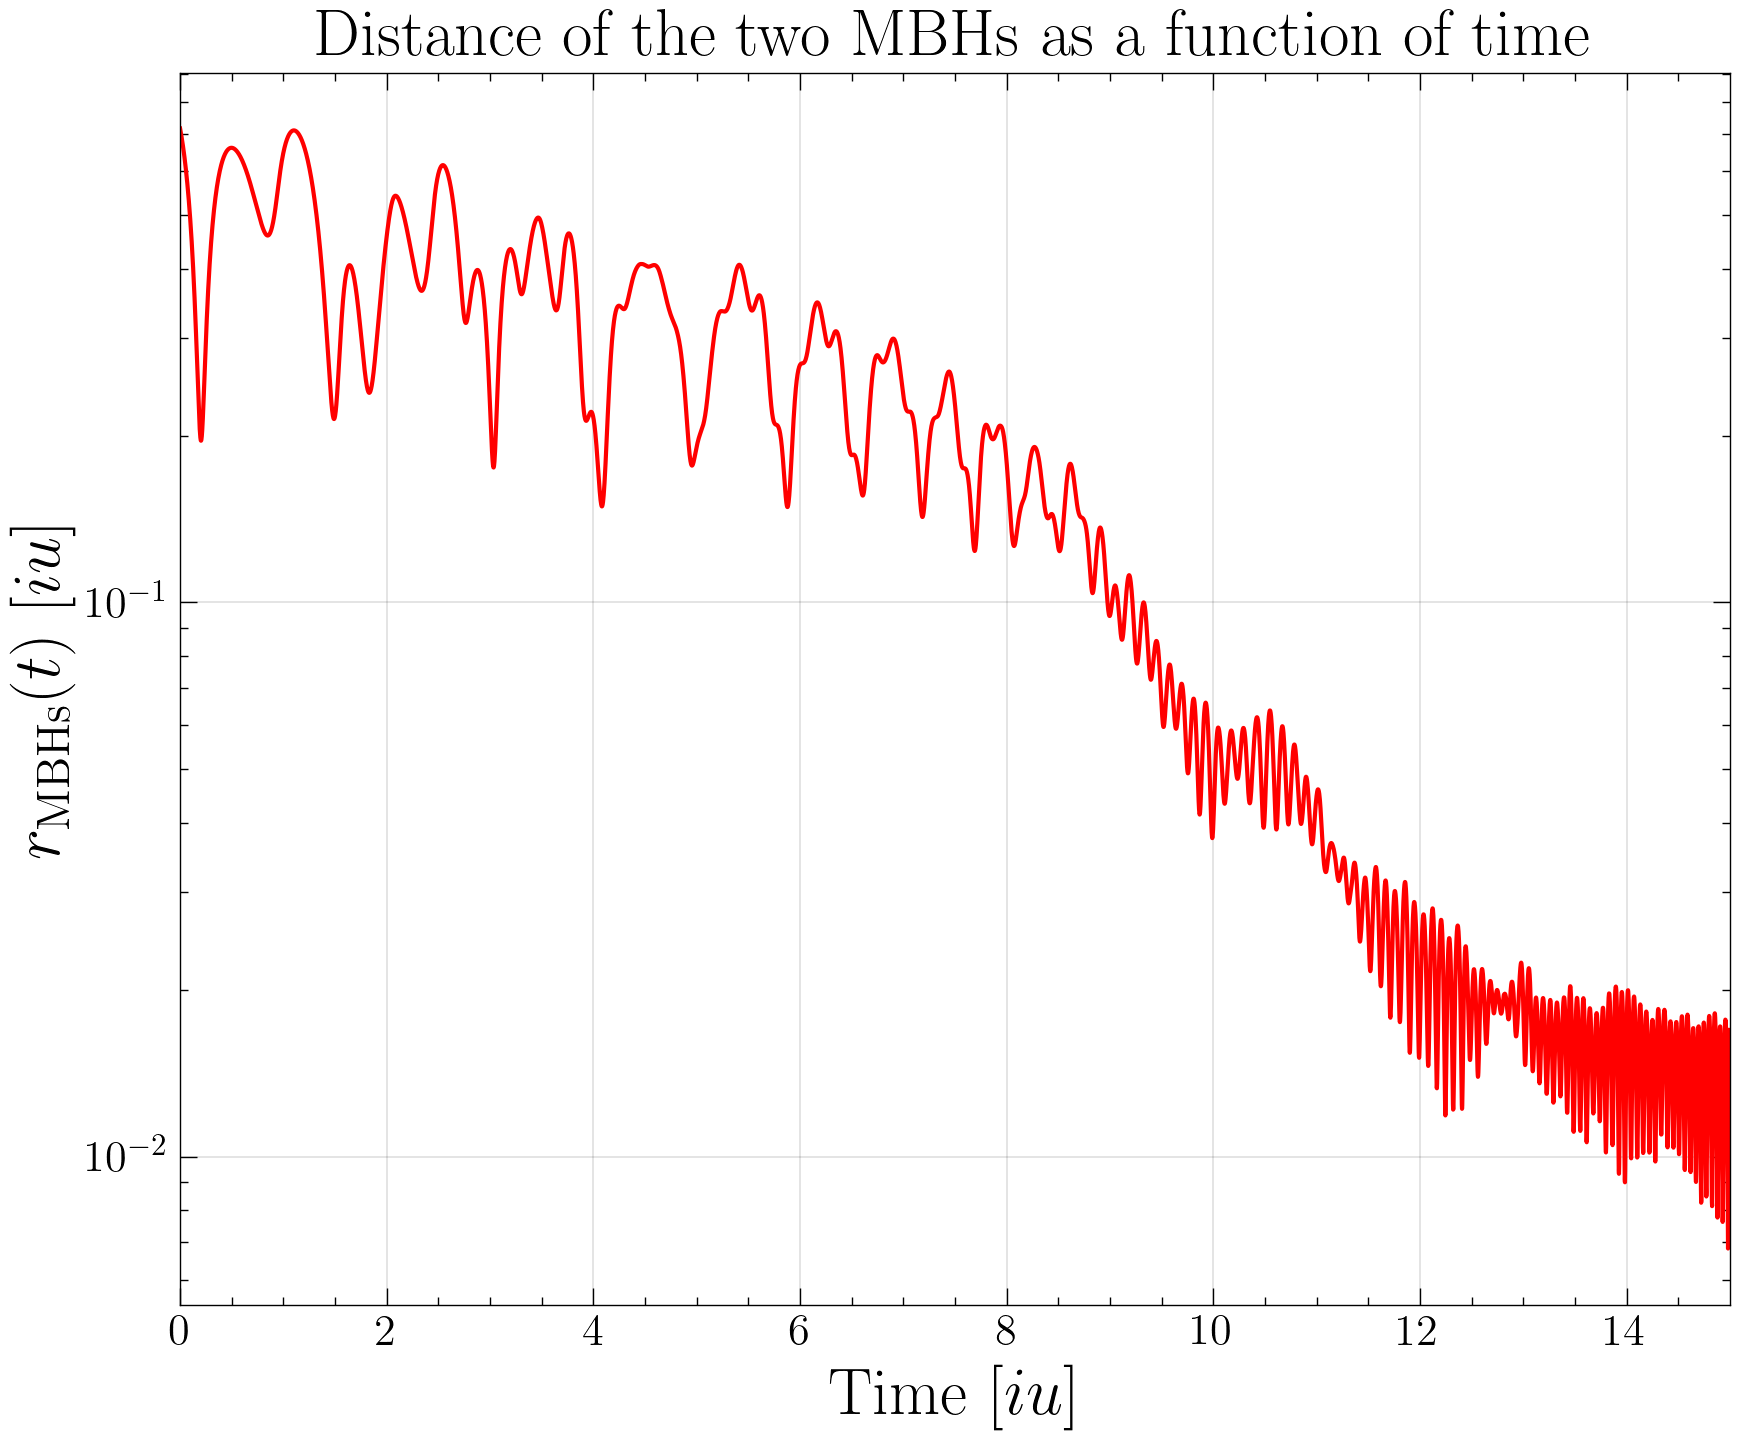

In [58]:
dist_mbhs = Dist(x[-1,:], y[-1,:], z[-1,:], x[-2,:], y[-2,:], z[-2,:])
plt.plot(time, dist_mbhs, color='red')
plt.xlim(0, time[-1])
plt.yscale('log')
plt.title('Distance of the two MBHs as a function of time')
plt.xlabel('Time $[iu]$')
plt.ylabel('$r_{\\rm{MBHs}} (t)$ $[iu]$');

# Center of mass of the MBH1-MBH2 system

In [69]:
CMbinary_pos_vector = (np.array([x[-1], y[-1], z[-1]]) + np.array([x[-2], y[-2], z[-2]]))/2
CMbinary_v_vector = (np.array([vx[-1], vy[-1], vz[-1]]) + np.array([vx[-2], vy[-2], vz[-2]]))/2

In [70]:
pos_CMbinary_mbh1 = np.array([x[-1], y[-1], z[-1]]) - CMbinary_pos_vector
pos_CMbinary_mbh2 =  np.array([x[-2], y[-2], z[-2]]) - CMbinary_pos_vector
v_CMbinary_mbh1 = np.array([vx[-1], vy[-1], vz[-1]]) - CMbinary_v_vector
v_CMbinary_mbh2 = np.array([vx[-2], vy[-2], vz[-2]]) - CMbinary_v_vector

In [77]:
angmom_CMbinary_mbh1 = np.cross(pos_CMbinary_mbh1.T, v_CMbinary_mbh1.T).T
angmom_CMbinary_mbh2 = np.cross(pos_CMbinary_mbh2.T, v_CMbinary_mbh2.T).T

angmom_binary = angmom_CMbinary_mbh1 + angmom_CMbinary_mbh2

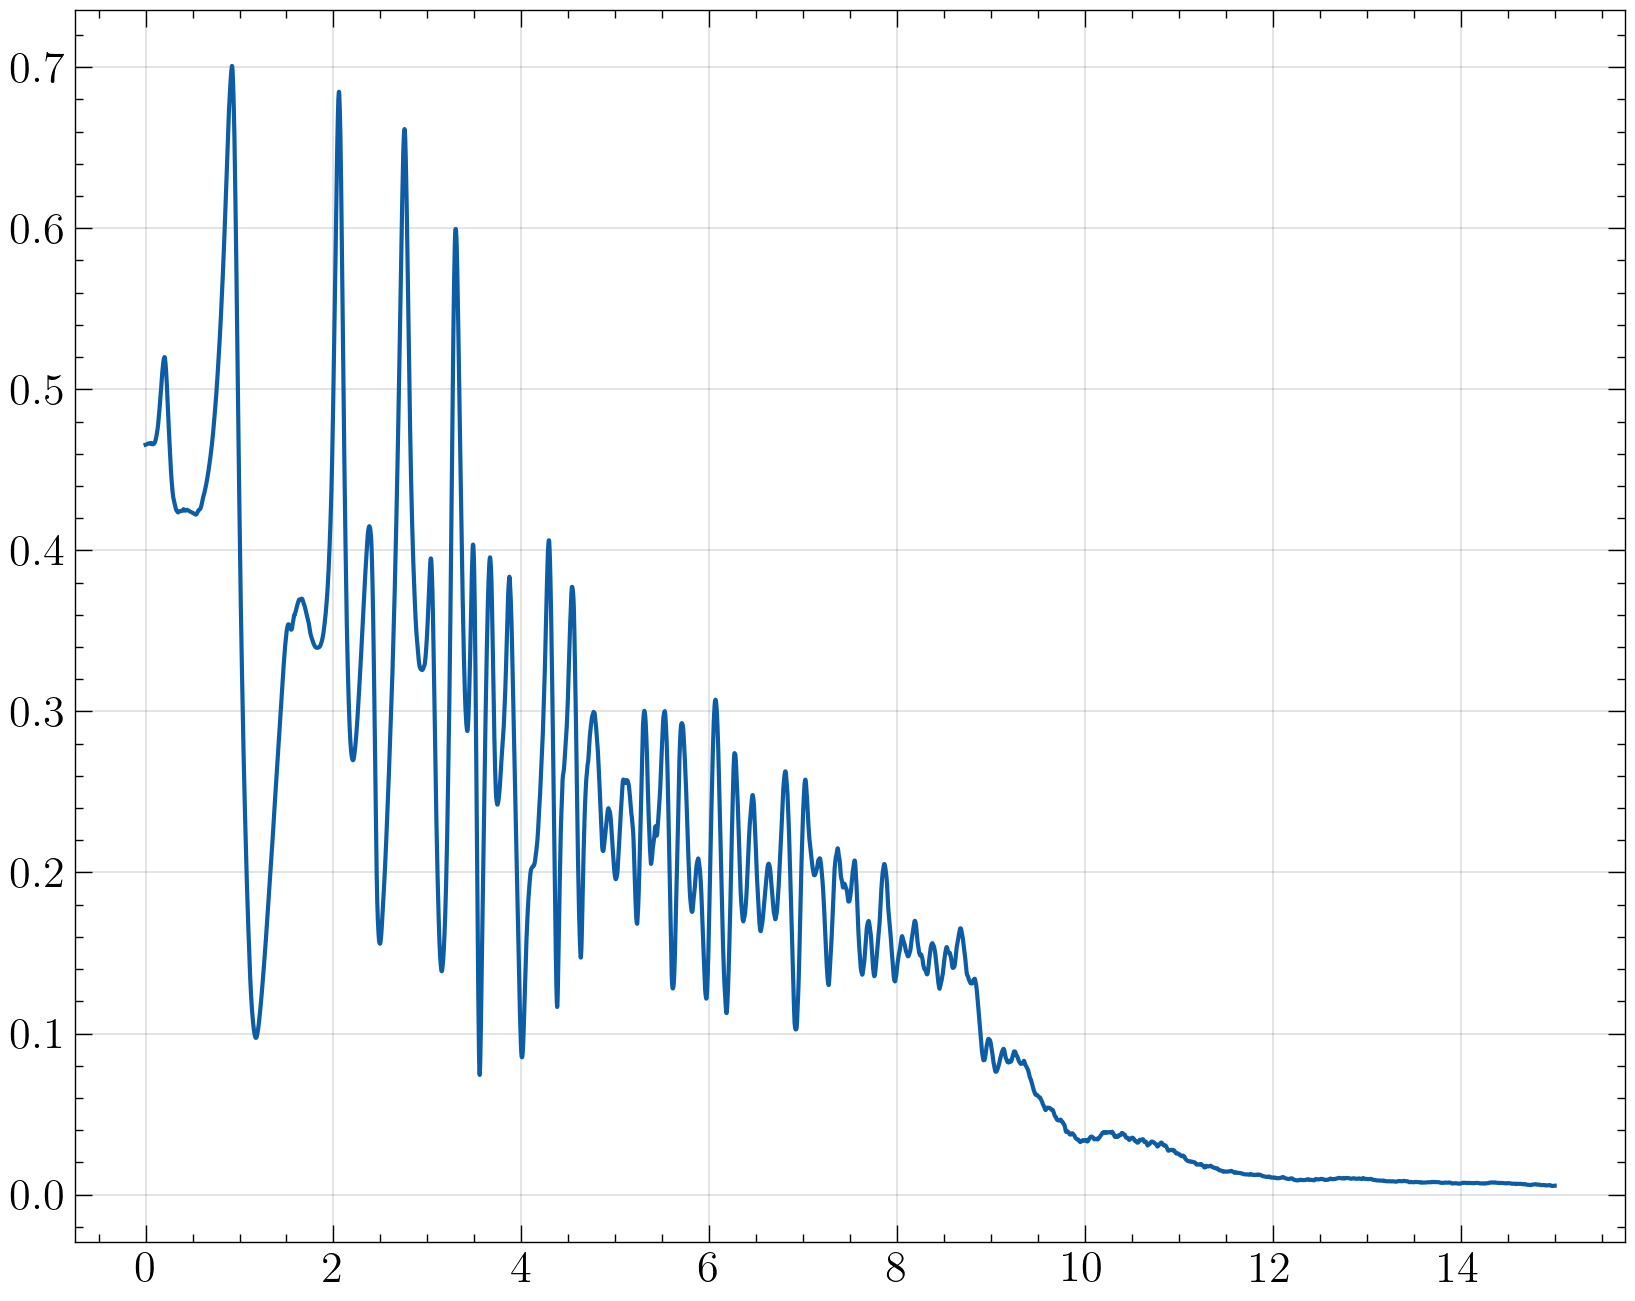

In [72]:
plt.plot(time, np.linalg.norm(angmom_binary, axis=1))

$\vec{r}_{1,\perp} = \vec{r}_1 - \vec{r}_{1,\parallel} = \vec{r}_1 - \dfrac{\vec{r}_1 \cdot \vec{l}}{l^2}\, \vec{l}$

In [100]:
pos_CMbinary_mbh1_orthogonal = pos_CMbinary_mbh1 - angmom_binary*(np.array([np.dot(pos_CMbinary_mbh1[:,i], angmom_binary[:,i]) for i in range(len(time))])/np.linalg.norm(angmom_binary, axis=0)**2)
pos_CMbinary_mbh2_orthogonal = pos_CMbinary_mbh2 - angmom_binary*(np.array([np.dot(pos_CMbinary_mbh2[:,i], angmom_binary[:,i]) for i in range(len(time))])/np.linalg.norm(angmom_binary, axis=0)**2)

In [102]:
pos_CMbinary_mbh1

array([[ 0.35829398,  0.35664069,  0.35495866, ...,  0.00470736,
         0.00468991,  0.0045886 ],
       [ 0.        , -0.00057572, -0.00115144, ...,  0.0058323 ,
         0.00647201,  0.00699236],
       [ 0.        ,  0.00116492,  0.0023298 , ..., -0.00223447,
        -0.0017873 , -0.0013057 ]])

In [101]:
pos_CMbinary_mbh1_orthogonal

array([[ 0.35829398,  0.35664069,  0.35495866, ...,  0.00470736,
         0.00468991,  0.0045886 ],
       [ 0.        , -0.00057572, -0.00115144, ...,  0.0058323 ,
         0.00647201,  0.00699236],
       [ 0.        ,  0.00116492,  0.0023298 , ..., -0.00223447,
        -0.0017873 , -0.0013057 ]])

# Animation: orbit of the perturber

In [17]:
time_interval = int(len(time)/10)
print(f'time_interval = {time[time_interval]}')

orbit_plotlimits = np.max([dist_mbh1, dist_mbh2])
print(f'orbit_plotlimits = {orbit_plotlimits}')

time_interval = 1.5000141
orbit_plotlimits = 0.556114962078056


In [18]:
animate_orbit = False

if animate_orbit:
    # if len(time)=N, then the animation will have N/k frames
    k = 1
    nframes = int(len(time)/k)
    
    # Set properties of the scatter plot 
    s_cm = 5
    s_mbh = 30
    
    # Define the figure
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 2, width_ratios=[1.2, 1])
    ax1 = fig.add_subplot(gs[:, 0], projection='3d')
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    title = fig.suptitle(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{MBHs}}}} = {M_mbh:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[0]:.2f}$', fontsize=30, y=0.92)   

    # Axis 1
    ax1.set_box_aspect([1, 1, 1])
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.set_xlim(-orbit_plotlimits, orbit_plotlimits)
    ax1.set_ylim(-orbit_plotlimits, orbit_plotlimits)
    ax1.set_zlim(-orbit_plotlimits, orbit_plotlimits)
    plot_CM = ax1.scatter(0, 0, 0, c='red', s=s_cm, edgecolors='black', linewidths=0.1, label='CM')
    plot_mbh1 = ax1.scatter([], [], [], c='black', s=s_mbh, label='MBH1')
    plot_mbh2 = ax1.scatter([], [], [], c='darkred', s=s_mbh, label='MBH2')
    plot_mbh1_orbit, = ax1.plot([], [], [], c='black', ls='--', lw=1, alpha=0.5)
    plot_mbh2_orbit, = ax1.plot([], [], [], c='darkred', ls='--', lw=1, alpha=0.5)
    ax1.legend()

    # Axis 2
    ax2.set_xlim(0, time[-1])
    ax2.set_ylim(0, 1.05*np.max([dist_mbh1, dist_mbh2]))
    ax2.set_xlabel('Time $[iu]$')
    ax2.set_ylabel('$r (t)$ $[iu]$')
    dist_mbh1_plot, = ax2.plot([], [], c='red', label='$r_{\\rm{MBH1}} (t)$ $[iu]$')
    dist_mbh2_plot, = ax2.plot([], [], c='royalblue', label='$r_{\\rm{MBH2}} (t)$ $[iu]$')
    dist_mbh_plot_vline = ax2.axvline(0, linestyle='--', lw=1, c='black', zorder=0)
    
    # Axis 3
    ax3.set_xlim(0, time[-1])
    ax3.set_ylim(0, 1.05*np.max([v_mbh1, v_mbh2]))
    ax3.set_xlabel('Time $[iu]$')
    ax3.set_ylabel('$v (t)$ $[iu]$')
    v_mbh1_plot, = ax3.plot([], [], c='red', label='$v_{\\rm{MBH1}} (t)$ $[iu]$')
    v_mbh2_plot, = ax3.plot([], [], c='royalblue', label='$v_{\\rm{MBH2}} (t)$ $[iu]$')
    v_mbh_plot_vline = ax3.axvline(0, linestyle='--', lw=1, c='black', zorder=0)
 
    def animate(i):
        t = k*i
        time_left = t - time_interval
        
        print(f'frame {(i+1)}/{nframes}, {math.ceil(100*t/len(x[0]))}%', end='\r')
        
        title.set_text(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{MBHs}}}} = {M_mbh:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[t]:.2f}$')
        
        # Axis 1
        if t<time_interval:
            plot_mbh1_orbit.set_data(x[-1, :t], y[-1, :t])
            plot_mbh1_orbit.set_3d_properties(z[-1, :t])
            plot_mbh2_orbit.set_data(x[-2, :t], y[-2, :t])
            plot_mbh2_orbit.set_3d_properties(z[-2, :t])
        else:
            plot_mbh1_orbit.set_data(x[-1, time_left:t], y[-1, time_left:t])
            plot_mbh1_orbit.set_3d_properties(z[-1, time_left:t])
            plot_mbh2_orbit.set_data(x[-2, time_left:t], y[-2, time_left:t])
            plot_mbh2_orbit.set_3d_properties(z[-2, time_left:t])
        
        plot_mbh1._offsets3d = ([x[-1, t]], [y[-1, t]], [z[-1, t]])
        plot_mbh2._offsets3d = ([x[-2, t]], [y[-2, t]], [z[-2, t]])
        
        
        # Axis 2
        dist_mbh1_plot.set_data([time[:t]], [dist_mbh1[:t]])
        dist_mbh2_plot.set_data([time[:t]], [dist_mbh2[:t]])
        dist_mbh_plot_vline.set_xdata([time[t], time[t]])


        # Axis 3
        v_mbh1_plot.set_data([time[:t]], [v_mbh1[:t]])
        v_mbh2_plot.set_data([time[:t]], [v_mbh2[:t]])
        v_mbh_plot_vline.set_xdata([time[t], time[t]])
        
        
        return fig,
    
    ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=1, blit=True)
    #ani.save('friction_orbit.gif', writer=animation.FFMpegWriter(fps=60), dpi=100)
    ani.save(name+'_orbit.mp4', writer=animation.FFMpegWriter(fps=40, bitrate=-1, codec='h264'), dpi=200)

# Full distribution animation

In [19]:
animate_distribution = False

if animate_distribution:
    # if len(x)=N, then the animation will have N/k frames
    k = 1
    nframes = int(len(time)/k)
    
    # Set properties of the scatter plot 
    s_cm = 5
    s_mbh = 20
    s_particles = 7
    alpha_particles = 0.45
    
    # Define the figure
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(20, 20))
    title = fig.suptitle(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{MBHs}}}} = {M_mbh:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[0]:.2f}$', fontsize=30, y=0.92)
    
    ax.set_box_aspect([1, 1, 1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-orbit_plotlimits, orbit_plotlimits)
    ax.set_ylim(-orbit_plotlimits, orbit_plotlimits)
    ax.set_zlim(-orbit_plotlimits, orbit_plotlimits)
    
    # Define the objects
    plot_CM = ax.scatter(0, 0, 0, c='red', s=s_cm, edgecolors='black', linewidths=0.1, label='CM')
    plot_mbh1 = ax.scatter([], [], [], c='black', s=s_mbh, label='MBH1')
    plot_mbh2 = ax.scatter([], [], [], c='darkred', s=s_mbh, label='MBH2')
    plot_mbh1_orbit, = ax.plot([], [], [], c='black', ls='--', lw=1, alpha=0.5)
    plot_mbh2_orbit, = ax.plot([], [], [], c='darkred', ls='--', lw=1, alpha=0.5)
    plot_particles = ax.scatter([], [], [], c='orange', s=s_particles, alpha=alpha_particles, linewidths=0)
    ax.legend(loc='upper right', fontsize=30)
    
    def animate(i):
        t = k*i
        time_left = t - time_interval
        coeff = 1+(i/nframes)*10
        
        print(f'frame {(i+1)}/{nframes}, {math.ceil(100*t/len(x[0]))}%', end='\r')
        
        title.set_text(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{MBHs}}}} = {M_mbh:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[t]:.2f}$')
        
        if t<time_interval:
            plot_mbh1_orbit.set_data(x[-1, :t], y[-1, :t])
            plot_mbh1_orbit.set_3d_properties(z[-1, :t])
            plot_mbh2_orbit.set_data(x[-2, :t], y[-2, :t])
            plot_mbh2_orbit.set_3d_properties(z[-2, :t])
        else:
            plot_mbh1_orbit.set_data(x[-1, time_left:t], y[-1, time_left:t])
            plot_mbh1_orbit.set_3d_properties(z[-1, time_left:t])
            plot_mbh2_orbit.set_data(x[-2, time_left:t], y[-2, time_left:t])
            plot_mbh2_orbit.set_3d_properties(z[-2, time_left:t])
        
        plot_mbh1._offsets3d = ([x[-1, t]], [y[-1, t]], [z[-1, t]])
        plot_mbh1.set(sizes=[s_mbh*(coeff**2)])
        
        plot_mbh2._offsets3d = ([x[-2, t]], [y[-2, t]], [z[-2, t]])
        plot_mbh2.set(sizes=[s_mbh*(coeff**2)])
        
        plot_particles._offsets3d = (x[:-2, t], y[:-2, t], z[:-2, t])
        plot_particles.set(sizes=[s_particles*(coeff**2)], alpha=alpha_particles/(coeff/2))
        
        # Shrink the axes
        orbit_plotlimits_temp = orbit_plotlimits/coeff
        ax.set_xlim(-orbit_plotlimits_temp, orbit_plotlimits_temp)
        ax.set_ylim(-orbit_plotlimits_temp, orbit_plotlimits_temp)
        ax.set_zlim(-orbit_plotlimits_temp, orbit_plotlimits_temp)
        
        return fig,
    
    ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=1, blit=True)
    #ani.save('friction.gif', writer=animation.FFMpegWriter(fps=60), dpi=100)
    ani.save(name+'_distribution.mp4', writer=animation.FFMpegWriter(fps=40, bitrate=-1, codec='h264'), dpi=100)

# Angular momentum animation

In [20]:
angmom_particles = np.linalg.norm(np.cross(np.array([x, y, z])[:,:,:].T, np.array([vx, vy, vz])[:,:,:].T), axis=2).T
angmom_particles.shape

(10002, 7501)

In [21]:
angmom_particles_dot = np.diff(angmom_particles)/np.diff(time)
angmom_particles_dot.shape

(10002, 7500)

In [22]:
angmom_particles_dot = np.hstack([angmom_particles_dot, np.array([angmom_particles_dot[:,-1]]).T])
angmom_particles_dot.shape

(10002, 7501)

In [23]:
animate_distribution = False

# Create the color array
angmom_log = np.log10(np.abs(angmom_particles_dot[:-2,:]))
norm = plt.Normalize(vmin=np.quantile(angmom_log, 0.005), vmax=np.max(angmom_log))
colors = plt.cm.jet(norm(angmom_log))

if animate_distribution:
    # if len(x)=N, then the animation will have N/k frames
    k = 1
    nframes = int(len(time)/k)
    
    # Set properties of the scatter plot
    s_cm = 5
    s_mbh = 20
    s_particles = 7
    alpha_particles = 0.7
    
    # Define the figure
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(20, 20))
    title = fig.suptitle(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{MBHs}}}} = {M_mbh:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[0]:.2f}$', fontsize=30, y=0.92)
    
    ax.set_box_aspect([1, 1, 1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-orbit_plotlimits, orbit_plotlimits)
    ax.set_ylim(-orbit_plotlimits, orbit_plotlimits)
    ax.set_zlim(-orbit_plotlimits, orbit_plotlimits)
    
    # Define the objects
    plot_CM = ax.scatter(0, 0, 0, c='red', s=s_cm, edgecolors='black', linewidths=0.1, label='CM')
    plot_mbh1 = ax.scatter([], [], [], c='black', s=s_mbh, label='MBH1')
    plot_mbh2 = ax.scatter([], [], [], c='darkred', s=s_mbh, label='MBH2')
    plot_mbh1_orbit, = ax.plot([], [], [], c='black', ls='--', lw=1, alpha=0.5)
    plot_mbh2_orbit, = ax.plot([], [], [], c='darkred', ls='--', lw=1, alpha=0.5)
    plot_particles = ax.scatter([], [], [], s=s_particles, alpha=alpha_particles, linewidths=0)
    ax.legend(loc='upper right', fontsize=30)
    
    # Colorbar
    plot_particles_colorbar = ax.scatter(x[:-2, 0], y[:-2, 0], z[:-2, 0], c=angmom_log[:,0], norm=norm, cmap=plt.cm.jet, s=0, alpha=alpha_particles, linewidths=0)
    cax = fig.add_axes([0.9, 0.2, 0.02, 0.5])
    fig.colorbar(plot_particles_colorbar, cax=cax, label='$\log_{10}|\dot{\\vec{L}}|$')
    plot_particles_colorbar = []
    
    
    def animate(i):
        t = k*i
        time_left = t - time_interval
        
        print(f'frame {(i+1)}/{nframes}, {math.ceil(100*t/len(x[0]))}%', end='\r')
        
        title.set_text(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{MBHs}}}} = {M_mbh:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[t]:.2f}$')
        
        if t<time_interval:
            plot_mbh1_orbit.set_data(x[-1, :t], y[-1, :t])
            plot_mbh1_orbit.set_3d_properties(z[-1, :t])
            plot_mbh2_orbit.set_data(x[-2, :t], y[-2, :t])
            plot_mbh2_orbit.set_3d_properties(z[-2, :t])
        else:
            plot_mbh1_orbit.set_data(x[-1, time_left:t], y[-1, time_left:t])
            plot_mbh1_orbit.set_3d_properties(z[-1, time_left:t])
            plot_mbh2_orbit.set_data(x[-2, time_left:t], y[-2, time_left:t])
            plot_mbh2_orbit.set_3d_properties(z[-2, time_left:t])
        
        plot_mbh1._offsets3d = ([x[-1, t]], [y[-1, t]], [z[-1, t]])
        plot_mbh2._offsets3d = ([x[-2, t]], [y[-2, t]], [z[-2, t]])      
        
        plot_particles._offsets3d = (x[:-2, t], y[:-2, t], z[:-2, t])
        plot_particles.set(color=colors[:,t,:])
        
        return fig,
    
    ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=1, blit=True)
    #ani.save('friction.gif', writer=animation.FFMpegWriter(fps=60), dpi=100)
    ani.save(name+'_angmom.mp4', writer=animation.FFMpegWriter(fps=40, bitrate=-1, codec='h264'), dpi=100)

# Full distribution + angular momentum animation

In [24]:
animate_distribution = False

if animate_distribution:
    # if len(x)=N, then the animation will have N/k frames
    k = 1
    nframes = int(len(time)/k)
    
    # Set properties of the scatter plot 
    s_cm = 5
    s_mbh = 10
    s_particles = 2
    alpha_particles = 0.7
    
    # Define the figure
    fig = plt.figure(figsize=(24, 13.5))
    gs = fig.add_gridspec(3, 2, width_ratios=[1.4, 1])
    ax1 = fig.add_subplot(gs[:, 0], projection='3d')
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 1])
    title = fig.suptitle(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{MBHs}}}} = {M_mbh:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[0]:.2f}$', fontsize=25, y=0.95)
    
    # Axis 1
    ax1.set_box_aspect([1, 1, 1])
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.set_xlim(-orbit_plotlimits, orbit_plotlimits)
    ax1.set_ylim(-orbit_plotlimits, orbit_plotlimits)
    ax1.set_zlim(-orbit_plotlimits, orbit_plotlimits)
    plot_CM = ax1.scatter(0, 0, 0, c='red', s=s_cm, edgecolors='black', linewidths=0.1, label='CM')
    plot_mbh1 = ax1.scatter([], [], [], c='black', s=s_mbh, label='MBH1')
    plot_mbh2 = ax1.scatter([], [], [], c='darkred', s=s_mbh, label='MBH2')
    plot_mbh1_orbit, = ax1.plot([], [], [], c='black', ls='--', lw=0.5, alpha=0.5)
    plot_mbh2_orbit, = ax1.plot([], [], [], c='darkred', ls='--', lw=0.5, alpha=0.5)
    plot_particles = ax1.scatter([], [], [], s=s_particles, alpha=alpha_particles, linewidths=0)
    legend = ax1.legend(loc='upper right', fontsize=20)
    for marker in legend.legend_handles: marker._sizes = marker._sizes*7
    
    # Axis 2
    ax2.set_xlim(0, time[-1])
    ax2.set_ylim(bottom=0.95*np.min([dist_mbh1, dist_mbh2]) , top=1.05*np.max([dist_mbh1, dist_mbh2]))
    ax2.set_yscale('log')
    ax2.set_ylabel('$r (t)$ $[iu]$')
    ax2.tick_params(axis='x', which='both', labelbottom=False)
    dist_mbh1_plot, = ax2.plot([], [], c='black', lw=1, label='$r_{\\rm{MBH1}} (t)$ $[iu]$')
    dist_mbh2_plot, = ax2.plot([], [], c='darkred', lw=1, label='$r_{\\rm{MBH2}} (t)$ $[iu]$')
    dist_mbh_plot_vline = ax2.axvline(0, linestyle='--', lw=0.7, c='grey', zorder=0)
    
    # Axis 3
    ax3.set_xlim(0, time[-1])
    ax3.set_ylim(bottom=0.95*np.min([v_mbh1, v_mbh2]) , top=1.05*np.max([v_mbh1, v_mbh2]))
    ax3.set_yscale('log')
    ax3.set_ylabel('$v (t)$ $[iu]$')
    ax3.tick_params(axis='x', which='both', labelbottom=False)
    v_mbh1_plot, = ax3.plot([], [], c='black', lw=1, label='$v_{\\rm{MBH1}} (t)$ $[iu]$')
    v_mbh2_plot, = ax3.plot([], [], c='darkred', lw=1, label='$v_{\\rm{MBH2}} (t)$ $[iu]$')
    v_mbh_plot_vline = ax3.axvline(0, linestyle='--', lw=0.7, c='grey', zorder=0)
    
    # Axis 4
    ax4.set_xlim(0, time[-1])
    ax4.set_ylim(bottom=0.95*np.min([angmom_mbh1, angmom_mbh2]) , top=1.05*np.max([angmom_mbh1, angmom_mbh2]))
    ax4.set_yscale('log')
    ax4.set_xlabel('Time $[iu]$')
    ax4.set_ylabel('$L (t)$ $[iu]$')
    angmom_mbh1_plot, = ax4.plot([], [], c='black', lw=1, label='$L_{\\rm{MBH1}} (t)$ $[iu]$')
    angmom_mbh2_plot, = ax4.plot([], [], c='darkred', lw=1, label='$L_{\\rm{MBH2}} (t)$ $[iu]$')
    angmom_mbh_plot_vline = ax4.axvline(0, linestyle='--', lw=0.7, c='grey', zorder=0)
    
    # Colorbar
    plot_particles_colorbar = ax1.scatter(x[:-2, 0], y[:-2, 0], z[:-2, 0], c=angmom_log[:,0], norm=norm, cmap=plt.cm.jet, s=0, alpha=alpha_particles, linewidths=0)
    cax = fig.add_axes([0.08, 0.13, 0.01, 0.73])
    colorbar = fig.colorbar(plot_particles_colorbar, cax=cax)
    colorbar.ax.tick_params(labelsize=15)
    colorbar.set_label('$\log_{10}|\dot{\\vec{L}}|$', labelpad=-80, y=0.45)
    plot_particles_colorbar = []
    
    def animate(i):
        t = k*i
        coeff = 1+(i/nframes)*10
        time_left = int(t - time_interval/coeff)
        
        print(f'frame {(i+1)}/{nframes}, {math.ceil(100*t/len(x[0]))}%', end='\r')
        
        title.set_text(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{MBHs}}}} = {M_mbh:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[t]:.2f}$')
        
        # Axis 1
        if t<time_interval:
            plot_mbh1_orbit.set_data(x[-1, :t], y[-1, :t])
            plot_mbh1_orbit.set_3d_properties(z[-1, :t])
            plot_mbh2_orbit.set_data(x[-2, :t], y[-2, :t])
            plot_mbh2_orbit.set_3d_properties(z[-2, :t])
        else:
            plot_mbh1_orbit.set_data(x[-1, time_left:t], y[-1, time_left:t])
            plot_mbh1_orbit.set_3d_properties(z[-1, time_left:t])
            plot_mbh2_orbit.set_data(x[-2, time_left:t], y[-2, time_left:t])
            plot_mbh2_orbit.set_3d_properties(z[-2, time_left:t])
        
        plot_mbh1._offsets3d = ([x[-1, t]], [y[-1, t]], [z[-1, t]])
        plot_mbh1.set(sizes=[s_mbh*(coeff**2)])
        
        plot_mbh2._offsets3d = ([x[-2, t]], [y[-2, t]], [z[-2, t]])
        plot_mbh2.set(sizes=[s_mbh*(coeff**2)])
        
        plot_particles._offsets3d = (x[:-2, t], y[:-2, t], z[:-2, t])
        plot_particles.set(sizes=[s_particles*(coeff**2)], alpha=alpha_particles/(1+coeff/3), color=colors[:,t,:])
        
        # Shrink the axes
        orbit_plotlimits_temp = orbit_plotlimits/coeff
        ax1.set_xlim(-orbit_plotlimits_temp, orbit_plotlimits_temp)
        ax1.set_ylim(-orbit_plotlimits_temp, orbit_plotlimits_temp)
        ax1.set_zlim(-orbit_plotlimits_temp, orbit_plotlimits_temp)
        
        
        # Axis 2
        dist_mbh1_plot.set_data([time[:t]], [dist_mbh1[:t]])
        dist_mbh2_plot.set_data([time[:t]], [dist_mbh2[:t]])
        dist_mbh_plot_vline.set_xdata([time[t], time[t]])


        # Axis 3
        v_mbh1_plot.set_data([time[:t]], [v_mbh1[:t]])
        v_mbh2_plot.set_data([time[:t]], [v_mbh2[:t]])
        v_mbh_plot_vline.set_xdata([time[t], time[t]])
        
        
        # Axis 3
        angmom_mbh1_plot.set_data([time[:t]], [angmom_mbh1[:t]])
        angmom_mbh2_plot.set_data([time[:t]], [angmom_mbh2[:t]])
        angmom_mbh_plot_vline.set_xdata([time[t], time[t]])
        
        return fig,
    
    ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=1, blit=True)
    #ani.save(name+'_complete.gif', writer=animation.FFMpegWriter(fps=60), dpi=100)
    ani.save(name+'_complete.mp4', writer=animation.FFMpegWriter(fps=60, bitrate=24000, codec='h264'), dpi=100)

# 2D-histogram animation

Plot a 2D-histogram of the distribution of particles

In [25]:
animate_2Dhist = False
if animate_2Dhist:
    # if len(x)=N, then the animation will have N/k frames
    k = 1
    nframes = int(len(time)/k)
    
    # Define the binning
    nbins = int(20*np.log10(N))
    bins = np.linspace(-dist_plotlimits, dist_plotlimits, nbins)
    
    # Define the figure
    fig, axes = plt.subplots(1, 3, figsize=(22, 7))
    title = fig.suptitle(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{MBHs}}}} = {M_mbh:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[0]:.2f}$', fontsize=30, y=0.92)   
    
    # Colorbar
    hist = ax.hist2d(x[:, 0], y[:, 0], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet, alpha=0)
    cax = fig.add_axes([0.91, 0.14, 0.01, 0.71], label='$N_{points}/bin$')
    fig.colorbar(hist[3], cax, label='$N_{points}/bin$')
    hist = []
    
    def animate(i):
        t = k*i
        
        print(f'frame {(i+1)}/{nframes}, {math.ceil(100*t/len(x[0]))}%', end='\r')
        
        title.set_text(f'${N}$ particles , $b = {b}$ , $M = {M:.3f}$ , $M_{{\\rm{{MBHs}}}} = {M_mbh:.3f}$ , $\\theta = {theta:.2f}$ , $eps = {eps:.3f}$ , \n $t = {time[t]:.2f}$')
        
        ax = axes[0]
        ax.clear()
        ax.set_box_aspect(1)
        ax.hist2d(x[:, t], y[:, t], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
        ax.axvline(0, ls='--', lw=1,color='black')
        ax.axhline(0, ls='--', lw=1,color='black')
        ax.plot(x[-1, t], y[-1, t], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10, label='MBH1')
        ax.plot(x[-2, t], y[-2, t], 'o', color='darkred', markeredgewidth=1, markeredgecolor='darkred', markersize=10, label='MBH2')
        ax.set_xlim(-dist_plotlimits, dist_plotlimits)
        ax.set_ylim(-dist_plotlimits, dist_plotlimits)
        ax.set_xlabel('x [iu]')
        ax.set_ylabel('y [iu]')
        ax.legend()
    
        ax = axes[1]
        ax.clear()
        ax.set_box_aspect(1)
        ax.hist2d(x[:, t], z[:, t], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
        ax.axvline(0, ls='--', lw=1,color='black')
        ax.axhline(0, ls='--', lw=1,color='black')
        ax.plot(x[-1, t], z[-1, t], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10, label='MBH1')
        ax.plot(x[-2, t], z[-2, t], 'o', color='darkred', markeredgewidth=1, markeredgecolor='darkred', markersize=10, label='MBH2')
        ax.set_xlim(-dist_plotlimits, dist_plotlimits)
        ax.set_ylim(-dist_plotlimits, dist_plotlimits)
        ax.set_xlabel('x [iu]')
        ax.set_ylabel('z [iu]')
    
        ax = axes[2]
        ax.clear()
        ax.set_box_aspect(1)
        ax.hist2d(y[:, t], z[:, t], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
        ax.axvline(0, ls='--', lw=1,color='black')
        ax.axhline(0, ls='--', lw=1,color='black')
        ax.plot(y[-1, t], z[-1, t], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10, label='MBH1')
        ax.plot(y[-2, t], z[-2, t], 'o', color='darkred', markeredgewidth=1, markeredgecolor='darkred', markersize=10, label='MBH2')
        ax.set_xlim(-dist_plotlimits, dist_plotlimits)
        ax.set_ylim(-dist_plotlimits, dist_plotlimits)
        ax.set_xlabel('y [iu]')
        ax.set_ylabel('z [iu]')
            
        return fig,
    
    ani = animation.FuncAnimation(fig, animate, frames=int(nframes/k), interval=1, blit=True)
    #ani.save('friction_2Dhist.gif', writer=animation.FFMpegWriter(fps=60), dpi=100)
    ani.save(name+'_2Dhist.mp4', writer=animation.FFMpegWriter(fps=40, bitrate=-1, codec='h264'), dpi=200)

# Distance quantiles

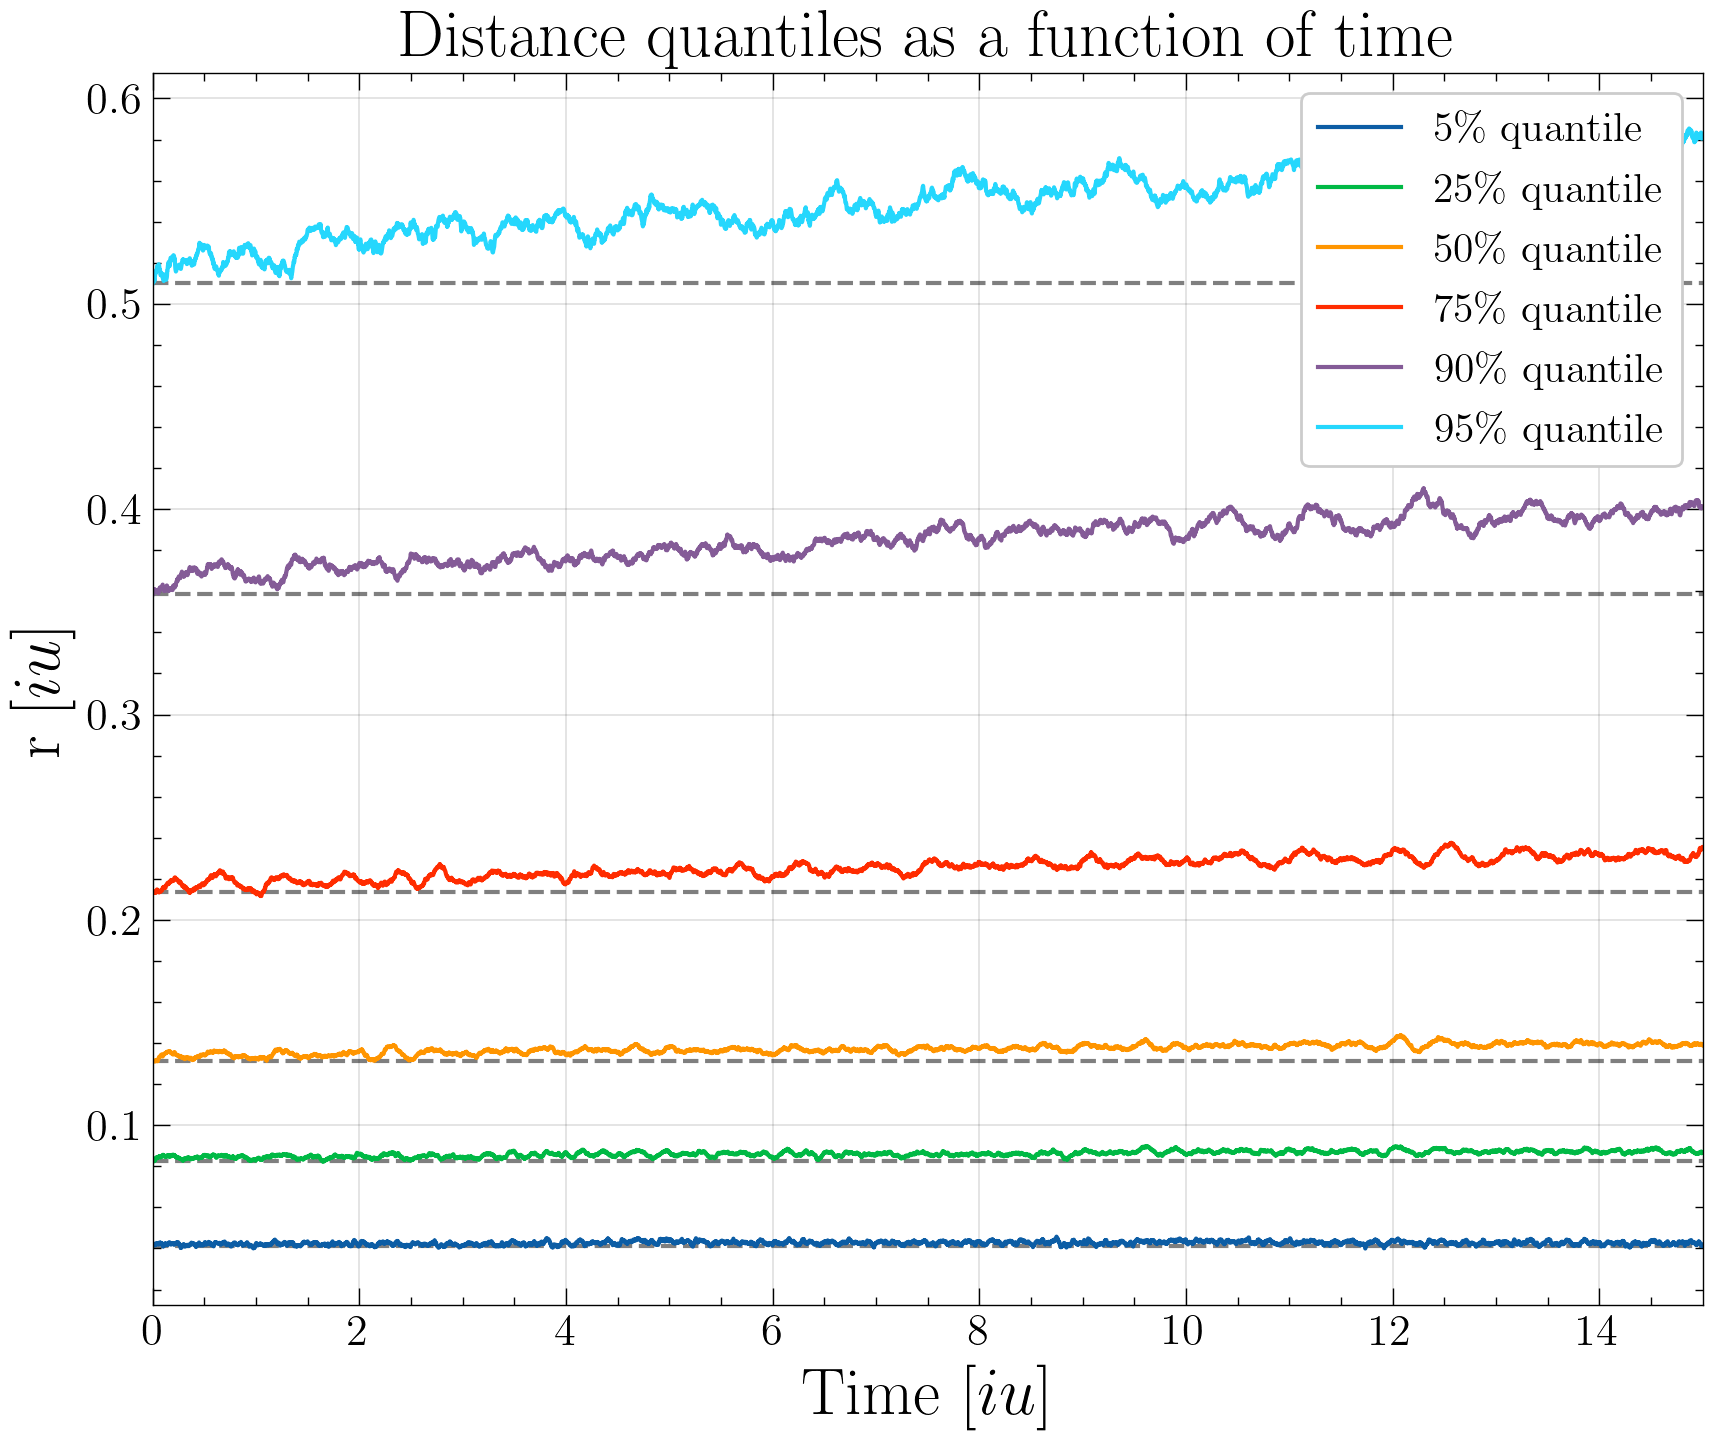

In [26]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.9, 0.95]
dist_quantiles = np.quantile(dist_particle, quantiles, axis=0)
for i in range(len(quantiles)):
    plt.axhline(dist_quantiles[i][0], ls='--', color='black', alpha=0.5)
    plt.plot(time, dist_quantiles[i], label=f'{int(100*quantiles[i])}\% quantile')
plt.xlim(0, time[-1])
plt.title('Distance quantiles as a function of time')
plt.xlabel('Time $[iu]$')
plt.ylabel('r $[iu]$')
plt.legend(loc='upper right', fontsize=15);

# Density profile

Let's compute the density profile of the Plummer sphere as a function of time, considering only the particles.

In [27]:
# Define radial bins
r_bins = np.linspace(0, np.max(np.quantile(dist_particle, 0.995, axis=0)), 40)
r_bins_rho = r_bins[:-1] + np.diff(r_bins)

M_particles = M - 2*M_mbh
N_particles = N - 2
m_particle = M_particles/N_particles

rho = np.ones([len(r_bins_rho), len(time)])
for i in range(len(r_bins_rho)):
    volume = (4*np.pi/3)*r_bins_rho[i]**3
    rho[i,:] = m_particle*np.sum(dist_particle[:-2,:]<r_bins_rho[i], axis=0)/volume

KeyboardInterrupt: 

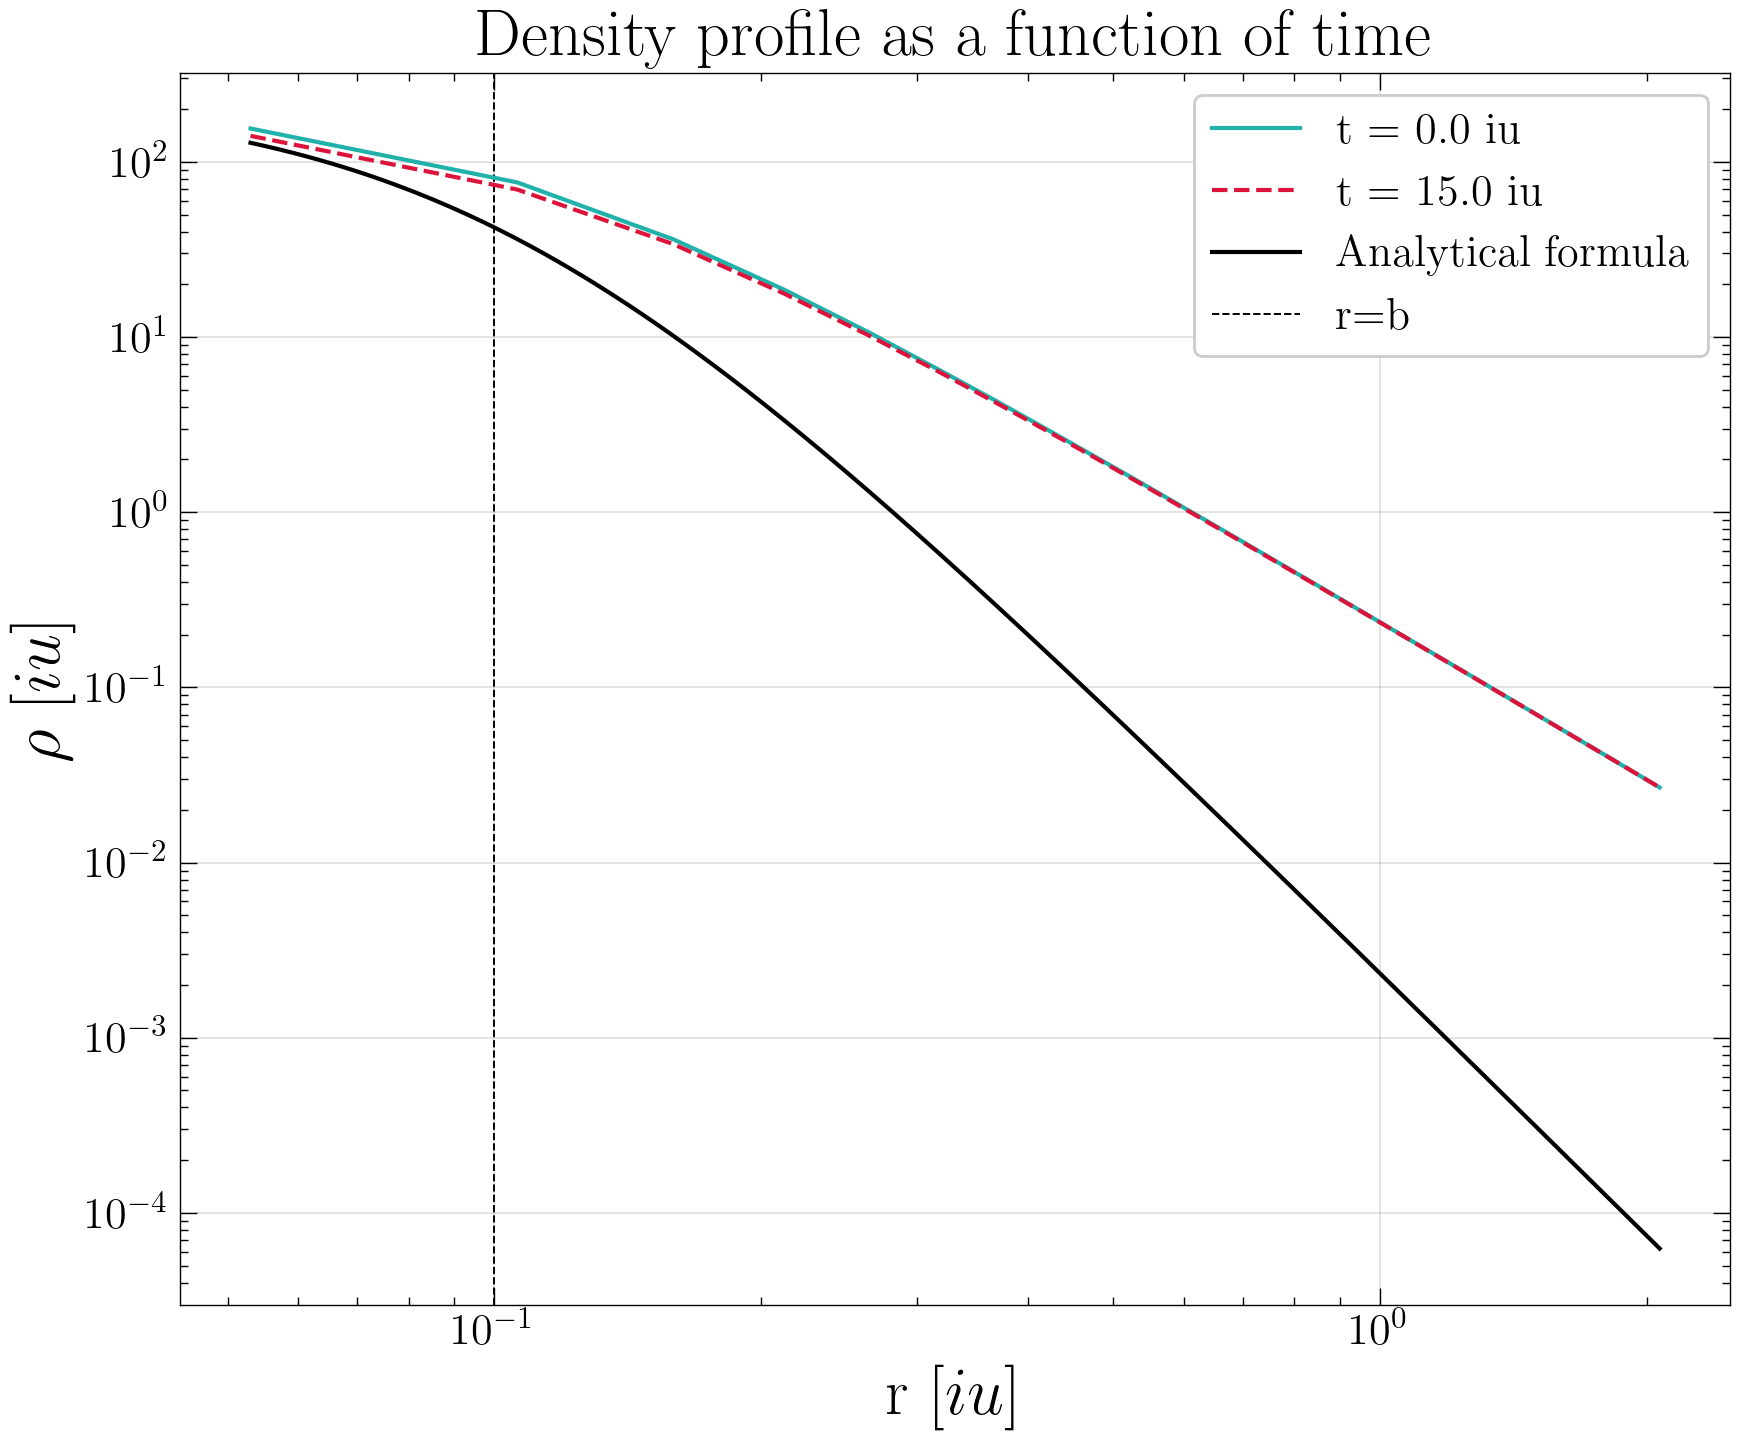

In [ ]:
plt.plot(r_bins_rho, rho[:,0], c='lightseagreen', label=f't = {time[0]:.1f} iu')
plt.plot(r_bins_rho, rho[:,-1], c='crimson', ls='--', label=f't = {time[-1]:.1f} iu')

x_dense = np.linspace(min(r_bins_rho), max(r_bins_rho), 1000)
y_dense = (3*M_particles/(4*np.pi*b**3))*(1+x_dense**2/b**2)**(-5/2)
plt.plot(x_dense, y_dense, c='black', label='Analytical formula')

plt.axvline(b, color='black', ls='--', lw=0.7, label='r=b', zorder=0)
plt.xscale('log')
plt.yscale('log')
plt.title('Density profile as a function of time')
plt.xlabel('r $[iu]$')
plt.ylabel('$\\rho$ $[iu]$')
plt.legend();